In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import xgboost as xgb
from catboost import CatBoostRegressor



In [3]:
train = pd.read_csv("./Dataset/train.csv", parse_dates=['date'])
stores = pd.read_csv('./Dataset/stores.csv')
transactions = pd.read_csv('./Dataset/transactions.csv', parse_dates=['date'])
oil = pd.read_csv('./Dataset/oil.csv', parse_dates=['date'])
events = pd.read_csv('./Dataset/holidays_events.csv', parse_dates=['date'])
test = pd.read_csv('Dataset/test.csv', parse_dates=['date'])

transfer_dates = events.loc[events['type'] == 'Transfer', 'date']
holiday_dates  = events.loc[
    (events['type'] == 'Holiday') & (~events['transferred']),
    'date'
]
real_holidays = pd.concat([transfer_dates, holiday_dates]).drop_duplicates()


In [4]:
def merge_external(df):
    df = df.merge(stores, on='store_nbr', how='left')
    df = df.merge(transactions, on=['date', 'store_nbr'], how='left')
    df = df.merge(oil, on='date', how='left')
    df = df.merge(events[['date','type','transferred']], on='date', how='left')
    return df

train_merged = merge_external(train)
test_merged  = merge_external(test)

'''train = merge_external(train)
test  = merge_external(test)

train.to_csv("./Dataset/train_merged.csv", index=False)
test.to_csv("./Dataset/test_merged.csv", index=False)'''



'train = merge_external(train)\ntest  = merge_external(test)\n\ntrain.to_csv("./Dataset/train_merged.csv", index=False)\ntest.to_csv("./Dataset/test_merged.csv", index=False)'

## Feature engineering

In [5]:
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekends'] = df['dayofweek'].isin([5,6]).astype(int)

    df['promo']  = df['onpromotion'].astype(int)
    df['family']= df['family'].astype('category').cat.codes

    df['is_holiday'] = df['date'].isin(real_holidays).astype(int)
    df['is_bridge_day'] = (df['type_y'] == 'Bridge').astype(int)
    df['is_work_day'] = (df['type_y'] == 'Work Day').astype(int)
    df['is_additional_holiday'] = (df['type_y'] == 'Additional').astype(int)

    df['day'] = df['date'].dt.day
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_payday'] = ((df['day'] == 15) | (df['is_month_end'] == 1)).astype(int)

    quake_start = pd.to_datetime('2014-06-16')
    quake_end = quake_start + pd.Timedelta(days=30)
    df['post_earthquake'] = ((df['date'] >= quake_start) & (df['date'] <= quake_end)).astype(int)

    df['transactions'] = df['transactions'].fillna(0)
    df['oil_missing'] = df['dcoilwtico'].isna().astype(int)
    df['is_holiday'] = df['date'].isin(real_holidays).astype(int)
    df['dcoilwtico'] = df['dcoilwtico'].ffill().bfill()


    return df

train_merged = create_features(train_merged)
test_merged = create_features(test_merged)

    

In [6]:

cat_cols = ['city', 'state', 'type_x', 'family']
le = LabelEncoder()

for col in cat_cols:
    train_merged[col] = le.fit_transform(train_merged[col])


## EDA

In [6]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 28 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   store_nbr              int64         
 3   family                 int64         
 4   sales                  float64       
 5   onpromotion            int64         
 6   city                   int64         
 7   state                  int64         
 8   type_x                 int64         
 9   cluster                int64         
 10  transactions           float64       
 11  dcoilwtico             float64       
 12  type_y                 object        
 13  transferred            object        
 14  dayofweek              int32         
 15  month                  int32         
 16  year                   int32         
 17  weekends               int64         
 18  promo                 

In [7]:
train_merged.shape

(3054348, 28)

In [8]:
train_merged.head(50)

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,promo,is_holiday,is_bridge_day,is_work_day,is_additional_holiday,day,is_month_end,is_payday,post_earthquake,oil_missing
0,0,2013-01-01,1,0,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
1,1,2013-01-01,1,1,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
2,2,2013-01-01,1,2,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
3,3,2013-01-01,1,3,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
4,4,2013-01-01,1,4,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
5,5,2013-01-01,1,5,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
6,6,2013-01-01,1,6,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
7,7,2013-01-01,1,7,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
8,8,2013-01-01,1,8,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1
9,9,2013-01-01,1,9,0.0,0,18,12,3,13,...,0,1,0,0,0,1,0,0,0,1


In [9]:
train_merged.iloc[:,3:].describe()

,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,dayofweek,...,promo,is_holiday,is_bridge_day,is_work_day,is_additional_holiday,day,is_month_end,is_payday,post_earthquake,oil_missing
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,...,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.600000e+01,3.590209e+02,2.617480e+00,1.255556e+01,8.796296e+00,2.000000e+00,8.481481e+00,1.558656e+03,6.785992e+01,3.008168e+00,...,2.617480e+00,1.061844e-01,1.750292e-03,2.917153e-03,2.217036e-02,1.565694e+01,3.208868e-02,6.476079e-02,2.042007e-02,3.127188e-01
std,9.521906e+00,1.107286e+03,1.225494e+01,6.264737e+00,4.165021e+00,1.201851e+00,4.649735e+00,1.036468e+03,2.566330e+01,2.001442e+00,...,1.225494e+01,3.080735e-01,4.179987e-02,5.393185e-02,1.472374e-01,8.801398e+00,1.762357e-01,2.461033e-01,1.414323e-01,4.636009e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.619000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,4.000000e+00,9.310000e+02,4.632000e+01,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.600000e+01,1.100000e+01,0.000000e+00,1.400000e+01,1.000000e+01,2.000000e+00,8.500000e+00,1.332000e+03,5.341000e+01,3.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.400000e+01,1.960110e+02,0.000000e+00,1.800000e+01,1.200000e+01,3.000000e+00,1.300000e+01,1.980000e+03,9.572000e+01,5.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.200000e+01,1.247170e+05,7.410000e+02,2.100000e+01,1.500000e+01,4.000000e+00,1.700000e+01,8.359000e+03,1.106200e+02,6.000000e+00,...,7.410000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
train_merged['dcoilwtico'].mean()

np.float64(67.8599241540257)

In [11]:
print(train_merged.index)


RangeIndex(start=0, stop=3054348, step=1)


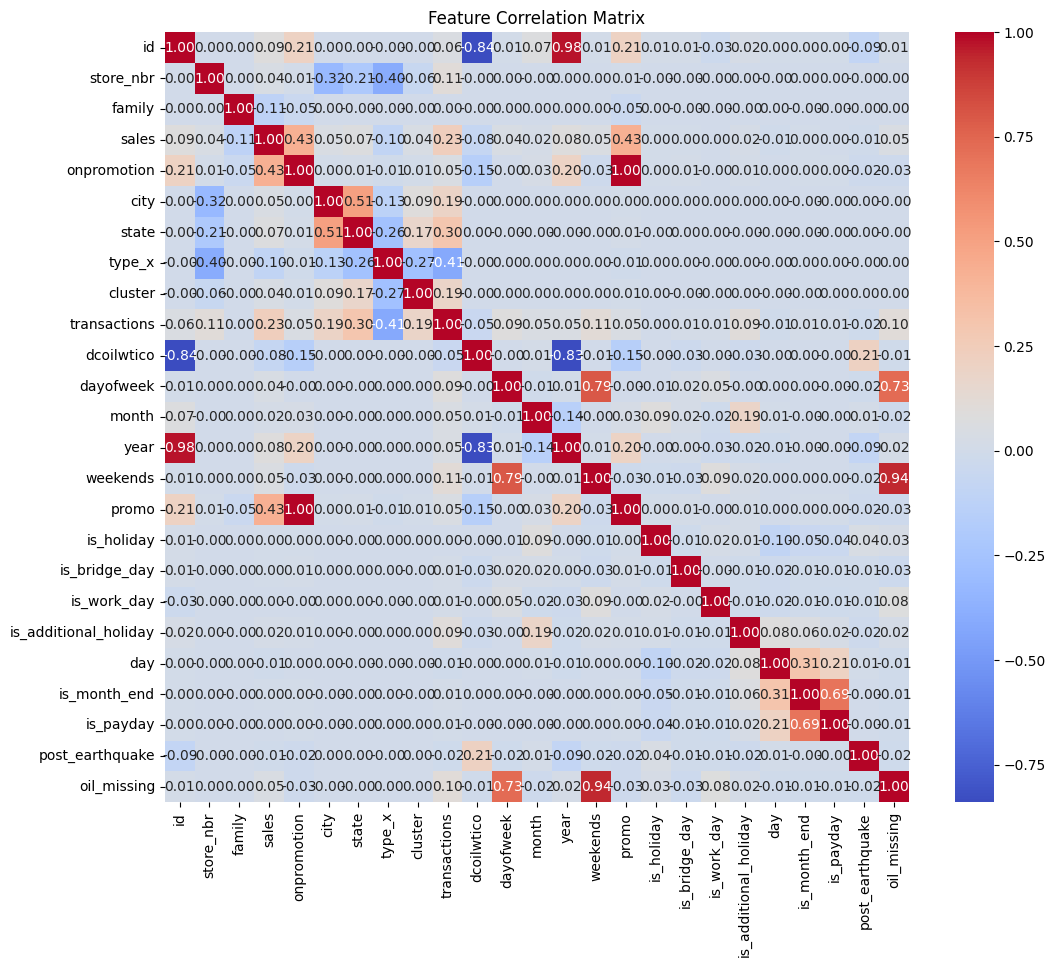

In [12]:
cor_matrix = train_merged.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [13]:
train_merged = train_merged.drop(columns=['promo', 'oil_missing', 'weekends', 'id'])

## Correlation

## Modelling

In [7]:
features = [
    'store_nbr','family','dayofweek','month','year',
    'transactions','dcoilwtico',
    'is_holiday','is_bridge_day','is_work_day','is_additional_holiday',
    'is_payday','post_earthquake'
]
X = train_merged[features]
y = train_merged['sales']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_val_scaled)
mse = mean_squared_log_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

In [16]:


final_model = RandomForestRegressor(
    random_state=42
)


y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

final_model.fit(
  X_train, y_train_log,
  
)

preds = np.expm1(final_model.predict(X_val))
rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
print(f"Validation RMSLE: {rmsle:.4f}")



Validation RMSLE: 0.3702


In [ ]:
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

val_preds = model.predict(X_val)
val_preds = np.clip(val_preds, 0, None)
y_val_clipped = np.clip(y_val, 0, None)

rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, val_preds))
print(f"Validation RMSLE: {rmsle:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2443478, number of used features: 13
[LightGBM] [Info] Start training from score 359.383665
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 131242
[200]	valid_0's l2: 101218
[300]	valid_0's l2: 89016.5
[400]	valid_0's l2: 80206.8
[500]	valid_0's l2: 73522.2
[600]	valid_0's l2: 69039.1
[700]	valid_0's l2: 65489.9
[800]	valid_0's l2: 62912.3
[900]	valid_0's l2: 60282.1
[1000]	valid_0's l2: 58503.8
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 58503.8
Validation RMSLE: 1.6001


In [ ]:

from xgboost.callback import EarlyStopping

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)
val_preds = model.predict(X_val)

val_preds_clipped = np.clip(val_preds, a_min=0, a_max=None)
y_val_clipped    = np.clip(y_val,    a_min=0, a_max=None)

rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, val_preds_clipped))
print(f"Validation RMSLE: {rmsle:.4f}")



[0]	validation_0-rmse:1046.61595
[100]	validation_0-rmse:293.72426
[200]	validation_0-rmse:256.88093
[300]	validation_0-rmse:241.82690
[400]	validation_0-rmse:231.33410
[500]	validation_0-rmse:223.63484
[600]	validation_0-rmse:218.49555
[700]	validation_0-rmse:214.21326
[800]	validation_0-rmse:210.82995
[900]	validation_0-rmse:206.47400
[999]	validation_0-rmse:203.89419
Validation RMSLE: 1.3929


In [ ]:
model = CatBoostRegressor(verbose=100)
model.fit(X_train, y_train)
val_preds = model.predict(X_val)

val_preds_clipped = np.clip(val_preds, a_min=0, a_max=None)
y_val_clipped    = np.clip(y_val,    a_min=0, a_max=None)

rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, val_preds_clipped))
print(f"Validation RMSLE: {rmsle:.4f}")


Learning rate set to 0.140438
0:	learn: 1016.4337724	total: 152ms	remaining: 2m 31s
100:	learn: 393.0718382	total: 8.38s	remaining: 1m 14s
200:	learn: 352.1217401	total: 16.6s	remaining: 1m 5s
300:	learn: 331.0627552	total: 24.8s	remaining: 57.7s
400:	learn: 315.6573406	total: 33s	remaining: 49.3s
500:	learn: 304.3083489	total: 41.2s	remaining: 41s
600:	learn: 296.9032200	total: 49.6s	remaining: 32.9s
700:	learn: 291.0956097	total: 57.8s	remaining: 24.7s
800:	learn: 285.8203797	total: 1m 6s	remaining: 16.4s
900:	learn: 281.1094726	total: 1m 14s	remaining: 8.16s
999:	learn: 277.3716966	total: 1m 22s	remaining: 0us
Validation RMSLE: 1.6111


In [ ]:
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

model.fit(
  X_train, y_train_log,
  
)

# invert before scoring
preds = np.expm1(model.predict(X_val))
rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
print(f"Validation RMSLE: {rmsle:.4f}")


Learning rate set to 0.140438
0:	learn: 2.5124089	total: 91.6ms	remaining: 1m 31s
100:	learn: 0.8150162	total: 9.53s	remaining: 1m 24s
200:	learn: 0.6836478	total: 18.6s	remaining: 1m 13s
300:	learn: 0.6265160	total: 27.9s	remaining: 1m 4s
400:	learn: 0.5916758	total: 36.5s	remaining: 54.5s
500:	learn: 0.5701277	total: 44.9s	remaining: 44.8s
600:	learn: 0.5544343	total: 53.2s	remaining: 35.3s
700:	learn: 0.5434494	total: 1m 1s	remaining: 26.2s
800:	learn: 0.5320703	total: 1m 9s	remaining: 17.3s
900:	learn: 0.5237138	total: 1m 17s	remaining: 8.56s
999:	learn: 0.5158945	total: 1m 26s	remaining: 0us
Validation RMSLE: 0.5171
